In [14]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import sys


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torch.nn.modules.loss import _WeightedLoss
from torch.utils.data import DataLoader, Dataset
import torch.utils.data as utils
import torchvision
from torchvision import datasets, models, transforms
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)

from albumentations.pytorch import ToTensorV2

from efficientnet_pytorch import EfficientNet
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random
import warnings
warnings.filterwarnings("ignore")

SyntaxError: invalid syntax (<ipython-input-14-7567a4b76812>, line 22)

In [2]:
BASE_DIR = "../../../data/cassava-leaf-disease-classification"
train_dir = os.path.join(BASE_DIR, 'train_images/')
test_dir = os.path.join(BASE_DIR, "test_images/")
print(train_dir)

../../../data/cassava-leaf-disease-classification\train_images/


In [3]:
#日付を取得
import datetime as dt

dt_now = dt.datetime.now()
directory_name = dt_now.strftime('%Y%m%d%H')
create_directory = BASE_DIR + '/models/' + directory_name
if(not (os.path.exists(create_directory))):
    os.mkdir(create_directory)

In [4]:
## config
class CFG:
    num_workers=0
    model_name='efficientnet-b3'
    size=300
    batch_size=8
    target_size=5
    target_col='label'
    n_fold=3
    seed = 2021
    learning_rate = 1e-5
    num_epochs = 25
    n_split = 3
    checkpoint_thres_loss = 1.0
    checkpoint_thres_acc = 80
    weights=torch.tensor([1.5, 1.0, 1.0, 1.0, 1.0]) #see 000_EDA.ipynb
    weight_decay=1e-5
    smoothing=0.12

In [5]:
np.random.seed(CFG.seed)
random.seed(CFG.seed)
torch.manual_seed(CFG.seed)
torch.cuda.manual_seed(CFG.seed)

In [6]:
df_train = pd.read_csv(BASE_DIR + "/train.csv")
df_train.head()


,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [7]:

model = EfficientNet.from_pretrained(CFG.model_name)
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, CFG.target_size)

Loaded pretrained weights for efficientnet-b3


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

cuda:0
GeForce RTX 2060
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


# Data Augumentation

In [9]:
def get_train_transforms():
    return Compose([
            RandomResizedCrop(CFG.size, CFG.size),
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            CoarseDropout(p=0.5),
            Cutout(p=0.5),
            ToTensorV2(p=1.0),
        ], p=1.)
  
        
def get_valid_transforms():
    return Compose([
            CenterCrop(CFG.size, CFG.size, p=1.),
            Resize(CFG.size, CFG.size),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)

## Data Loader

In [10]:
class ImageData(Dataset):
    def __init__(self, df, data_dir, transform, output_label=True):
        super().__init__()
        self.df = df
        self.data_dir = data_dir
        self.transform = transform
        self.output_label = output_label

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):       
        img_name = self.df.iloc[index,0]
        if self.output_label:
            label = self.df.iloc[index,1]
        
        img_path = os.path.join(self.data_dir, img_name)
        image = plt.imread(img_path)
        image = self.transform(image=image)

        # do label smoothing
        if self.output_label == True:
            return image, label
        else:
            return image

## CrossEntropyLoss

In [11]:
class SmoothCrossEntropyLoss(_WeightedLoss):
    def __init__(self, weight=CFG.weights, reduction='mean', smoothing=CFG.smoothing):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    @staticmethod
    def _smooth_one_hot(targets:torch.Tensor, n_classes:int, smoothing=0.0):
        assert 0 <= smoothing < 1
        with torch.no_grad():
            targets = torch.empty(size=(targets.size(0), n_classes),
                    device=targets.device) \
                .fill_(smoothing /(n_classes-1)) \
                .scatter_(1, targets.data.unsqueeze(1), 1.-smoothing)
        return targets

    def forward(self, inputs, targets):
        targets = SmoothCrossEntropyLoss._smooth_one_hot(targets, inputs.size(-1),
            self.smoothing)
        lsm = F.log_softmax(inputs, -1)

        if self.weight is not None:
            lsm = lsm * self.weight.unsqueeze(0)

        loss = -(targets * lsm).sum(-1)

        if  self.reduction == 'sum':
            loss = loss.sum()
        elif  self.reduction == 'mean':
            loss = loss.mean()

        return loss

## Helper Function

In [12]:
def Plot_Model_History(loss_tra_li,acc_tra_li,loss_val_li,acc_val_li):
    plt.figure(figsize=(12, 5))
    plt.subplot(2, 2, 1)
    plt.plot(loss_tra_li, label="train_loss")
    plt.plot(loss_val_li, label="val_loss")
    plt.legend()
    plt.subplot(2, 2, 2)
    plt.plot(acc_tra_li, label="train_acc")
    plt.plot(acc_val_li, label="val_acc")
    plt.legend()
    plt.show()
    
def Save_histroy(init=False):
    filename = "./log/" + directory_name
    if init:
        with open(filename+'.txt','w') as f:
            f.write("filename: 003_albumentations_smoothing.ipynb, model: {}, lr: {}, weights: {}. batchsize: {}, kfold: {}, epoch: {}, weght_decay: {}, smoothing: {}\n" 
            .format(CFG.model_name,CFG.learning_rate,CFG.weights, CFG.batch_size,CFG.n_split,CFG.num_epochs,CFG.weight_decay,CFG.smoothing))
    else:
        with open(filename+'.txt',mode='a') as f:
            f.write('\nkfold: {}, epoch: {}. train_loss: {}, train_acc: {}. val_loss: {}, val_acc: {}'
                    .format(fold_index+1, epoch + 1, train_loss, train_acc, val_loss, val_acc))
            
            
            
def Confusion_Matrix(train_true_li,train_pred_li,val_true_li,val_pred_li):
    plt.figure(figsize=(10,5))
    train_cm = confusion_matrix(train_true_li,train_pred_li)
    val_cm = confusion_matrix(val_true_li,val_pred_li)
    plt.subplot(1,2,1)
    sns.heatmap(train_cm, annot=True, cmap='Blues', cbar=False)
    plt.xlabel("taget")
    plt.ylabel("predict")
    plt.title("train")
    
    plt.subplot(1,2,2)
    sns.heatmap(val_cm, annot=True, cmap='Blues', cbar=False)
    plt.title("val")
    plt.xlabel("taget")
    plt.ylabel("predict")
    plt.show()
    
def Define_Model():
    m = EfficientNet.from_pretrained(CFG.model_name)
    num_ftrs = m._fc.in_features
    m._fc = nn.Linear(num_ftrs, CFG.target_size)
    return m.to(device)

Loaded pretrained weights for efficientnet-b3
Kfold: 1 - Epoch: 1 - Train_Loss: 1.232850 - Train_Acc: 64.5050 - Val_Loss: 1.076650 - Val_Acc: 74.120286
Kfold: 1 - Epoch: 2 - Train_Loss: 1.044489 - Train_Acc: 73.7100 - Val_Loss: 0.958102 - Val_Acc: 79.461657
Kfold: 1 - Epoch: 3 - Train_Loss: 0.977353 - Train_Acc: 77.3065 - Val_Loss: 0.905197 - Val_Acc: 81.620636
Kfold: 1 - Epoch: 4 - Train_Loss: 0.946848 - Train_Acc: 78.6596 - Val_Loss: 0.877607 - Val_Acc: 82.966494
Kfold: 1 - Epoch: 5 - Train_Loss: 0.923838 - Train_Acc: 79.7322 - Val_Loss: 0.858514 - Val_Acc: 83.905790
Kfold: 1 - Epoch: 6 - Train_Loss: 0.912396 - Train_Acc: 80.2089 - Val_Loss: 0.846103 - Val_Acc: 84.088041
Kfold: 1 - Epoch: 7 - Train_Loss: 0.896644 - Train_Acc: 80.9380 - Val_Loss: 0.835372 - Val_Acc: 84.536661
Kfold: 1 - Epoch: 8 - Train_Loss: 0.886386 - Train_Acc: 81.8003 - Val_Loss: 0.823491 - Val_Acc: 85.265667
Kfold: 1 - Epoch: 9 - Train_Loss: 0.875390 - Train_Acc: 82.1719 - Val_Loss: 0.820944 - Val_Acc: 85.307725


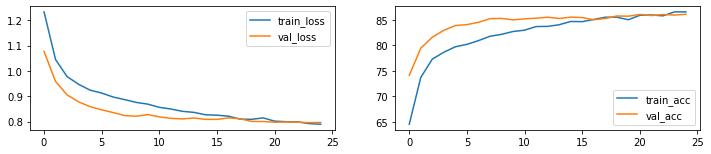

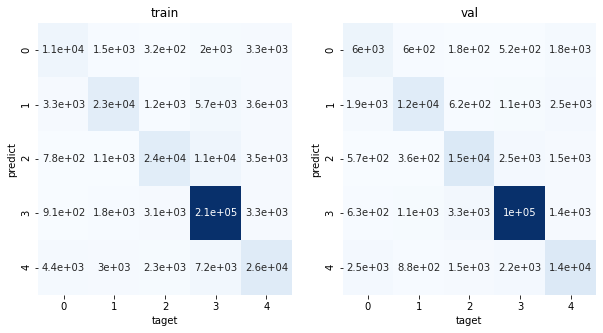

Loaded pretrained weights for efficientnet-b3
Kfold: 2 - Epoch: 1 - Train_Loss: 1.231466 - Train_Acc: 64.6407 - Val_Loss: 1.089195 - Val_Acc: 73.794167
Kfold: 2 - Epoch: 2 - Train_Loss: 1.048995 - Train_Acc: 73.7890 - Val_Loss: 0.960578 - Val_Acc: 79.430735
Kfold: 2 - Epoch: 3 - Train_Loss: 0.986426 - Train_Acc: 76.9015 - Val_Loss: 0.909320 - Val_Acc: 81.337633
Kfold: 2 - Epoch: 4 - Train_Loss: 0.949082 - Train_Acc: 78.5559 - Val_Loss: 0.873178 - Val_Acc: 82.809871
Kfold: 2 - Epoch: 5 - Train_Loss: 0.938454 - Train_Acc: 79.0326 - Val_Loss: 0.857482 - Val_Acc: 83.889512
Kfold: 2 - Epoch: 6 - Train_Loss: 0.918275 - Train_Acc: 80.2243 - Val_Loss: 0.850273 - Val_Acc: 83.889512
Kfold: 2 - Epoch: 7 - Train_Loss: 0.899916 - Train_Acc: 81.2969 - Val_Loss: 0.835851 - Val_Acc: 84.492428
Kfold: 2 - Epoch: 8 - Train_Loss: 0.889417 - Train_Acc: 81.3810 - Val_Loss: 0.825914 - Val_Acc: 85.011217
Kfold: 2 - Epoch: 9 - Train_Loss: 0.879518 - Train_Acc: 81.9769 - Val_Loss: 0.820646 - Val_Acc: 85.165451


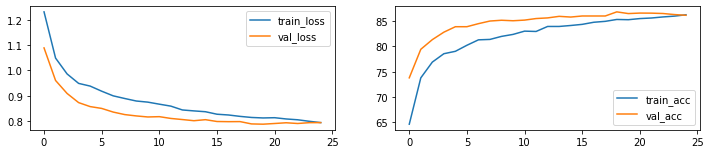

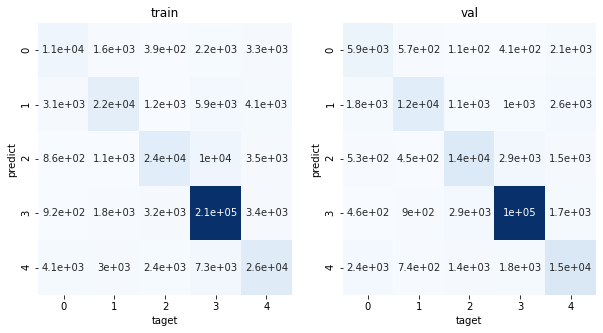

Loaded pretrained weights for efficientnet-b3
Kfold: 3 - Epoch: 1 - Train_Loss: 1.226685 - Train_Acc: 64.6267 - Val_Loss: 1.068537 - Val_Acc: 74.481211
Kfold: 3 - Epoch: 2 - Train_Loss: 1.039923 - Train_Acc: 73.7960 - Val_Loss: 0.947240 - Val_Acc: 79.949523
Kfold: 3 - Epoch: 3 - Train_Loss: 0.973687 - Train_Acc: 77.1959 - Val_Loss: 0.889845 - Val_Acc: 82.108805
Kfold: 3 - Epoch: 4 - Train_Loss: 0.945436 - Train_Acc: 78.7943 - Val_Loss: 0.868924 - Val_Acc: 83.174425
Kfold: 3 - Epoch: 5 - Train_Loss: 0.924185 - Train_Acc: 79.6144 - Val_Loss: 0.848573 - Val_Acc: 84.141896
Kfold: 3 - Epoch: 6 - Train_Loss: 0.909214 - Train_Acc: 80.7501 - Val_Loss: 0.837029 - Val_Acc: 84.744812
Kfold: 3 - Epoch: 7 - Train_Loss: 0.895537 - Train_Acc: 80.8482 - Val_Loss: 0.829035 - Val_Acc: 84.955132
Kfold: 3 - Epoch: 8 - Train_Loss: 0.888643 - Train_Acc: 81.5913 - Val_Loss: 0.815687 - Val_Acc: 85.011217
Kfold: 3 - Epoch: 9 - Train_Loss: 0.876774 - Train_Acc: 82.3835 - Val_Loss: 0.818021 - Val_Acc: 85.081324


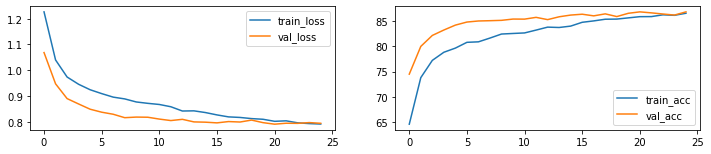

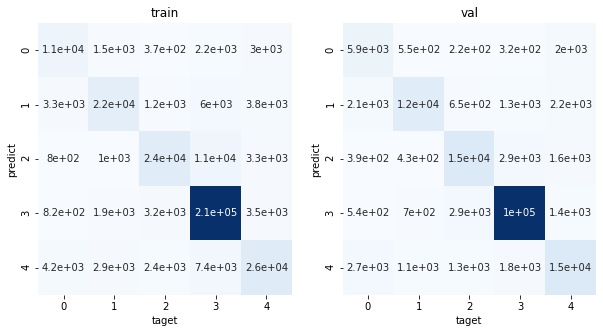

In [13]:
# n_splitsでKの数を指定
folds = StratifiedKFold(n_splits=CFG.n_split).split(np.arange(df_train.shape[0]), df_train["label"].values)
Save_histroy(init=True)
for fold_index, (train_index,val_index) in enumerate(folds):

    model = Define_Model()
    optimizer = optim.Adam(model.parameters(), lr=CFG.learning_rate)
    
    train = df_train.iloc[train_index].reset_index(drop=True)
    train_data = ImageData(df = train, data_dir = train_dir, transform = get_train_transforms())
    train_loader = DataLoader(dataset = train_data, batch_size = CFG.batch_size, num_workers=CFG.num_workers, pin_memory=True,shuffle=True)
    train_criterion = SmoothCrossEntropyLoss().to(device)
    
    val = df_train.iloc[val_index,:].reset_index(drop=True)
    val_data = ImageData(df = val, data_dir = train_dir, transform = get_valid_transforms())
    val_loader = DataLoader(dataset = val_data, batch_size = CFG.batch_size, num_workers=CFG.num_workers, pin_memory=True,shuffle=True)
    val_criterion = SmoothCrossEntropyLoss().to(device)
    train_epoch_log,val_epoch_log = [],[]
    train_acc_log,val_acc_log = [],[]
    train_taget_li,val_taget_li = [],[]
    train_pred_li,val_pred_li = [],[]

    for epoch in range(CFG.num_epochs):
        train_total = 0
        train_correct = 0
        train_loss_sum = 0
        val_total = 0
        val_correct = 0
        val_loss_sum = 0
        
        # train
        model.train()
        for idx, (data, target) in enumerate(train_loader):
            data, target = data['image'].to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = train_criterion(output, target)
            loss.backward()
            optimizer.step()  
            
            train_loss_sum += loss.item()
            train_total += target.size(0)
            _,predicted = output.max(1)
            train_correct += predicted.eq(target).sum().item()
            train_taget_li.extend(target.to('cpu').detach().numpy().copy().tolist())
            train_pred_li.extend(predicted.to('cpu').detach().numpy().copy().tolist())
            
            
        train_loss = train_loss_sum / len(train_loader)
        train_epoch_log.append(train_loss)
        train_acc = 100.0 * train_correct/train_total
        train_acc_log.append(train_acc)
        
        # val
        model.eval()
        with torch.no_grad():
            for idx, (data, target) in enumerate(val_loader):
                data, target = data['image'].to(device), target.to(device)
                output = model(data)
                loss = val_criterion(output, target)
                val_loss_sum += loss.item()
                val_total += target.size(0)
                _,predicted = output.max(1)
                val_correct += (predicted == target).sum().item()
                val_taget_li.extend(target.to('cpu').detach().numpy().copy().tolist())
                val_pred_li.extend(predicted.to('cpu').detach().numpy().copy().tolist())
                    
            val_loss = val_loss_sum / len(val_loader)
            val_epoch_log.append(val_loss)
            val_acc = 100.0 * val_correct/val_total
            val_acc_log.append(val_acc)
                
        print('Kfold: {} - Epoch: {} - Train_Loss: {:.6f} - Train_Acc: {:.4f} - Val_Loss: {:.6f} - Val_Acc: {:4f}'.format(fold_index+1, epoch + 1, train_loss, train_acc, val_loss, val_acc))
        Save_histroy(init=False)
        if (val_loss < CFG.checkpoint_thres_loss) & (val_acc > CFG.checkpoint_thres_acc):
            CFG.checkpoint_thres_loss = val_loss
            CFG.checkpoint_thres_acc = val_acc
            path = create_directory + "./"+ CFG.model_name + "_kfold_"+str(fold_index+1)+"_epoch"+str(epoch+1)+ "_Acc_" + str(val_acc) + '.pth'
            torch.save(model.state_dict(), path) 
        
    Plot_Model_History(train_epoch_log,train_acc_log,val_epoch_log,val_acc_log)
    Confusion_Matrix(train_taget_li,train_pred_li,val_taget_li,val_pred_li)